In [1]:
import os
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'
import torch
torch.set_grad_enabled(False)
import psutil
from lavis.models.eva_vit import create_eva_vit_g
from lavis.common.registry import registry
from omegaconf import OmegaConf
from PIL import Image
from tqdm import tqdm
import gc
import cv2

/opt/conda/envs/eval/lib/python3.8/site-packages/transformers/utils/generic.py:311: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(
/opt/conda/envs/eval/lib/python3.8/site-packages/transformers/utils/generic.py:311: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(


In [2]:
def print_mem_stats():
    mem = psutil.virtual_memory()
    total_system_memory = mem.total / (1024 ** 2)
    used_system_memory = mem.used / (1024 ** 2)
    total_gpu_memory = torch.cuda.get_device_properties(0).total_memory / (1024 ** 2)
    reserved_gpu_memory = torch.cuda.memory_reserved(0) / (1024 ** 2)
    allocated_gpu_memory = torch.cuda.memory_allocated(0) / (1024 ** 2)
    percent_gpu_total = (allocated_gpu_memory / total_gpu_memory)*100
    percent_gpu_reserved = (reserved_gpu_memory / total_gpu_memory)*100
    percent_cpu_total = (used_system_memory / total_system_memory)*100
    print(f"mem used gpu: {allocated_gpu_memory:.2f} MB, reserved gpu: {reserved_gpu_memory:.2f}MB -> {percent_gpu_total:.2f}% of total, {percent_gpu_reserved:.2f}% reserved")
    print(f"mem used cpu: {used_system_memory:.2f} MB -> {percent_cpu_total:.2f}% of total")

print_mem_stats()

mem used gpu: 0.00 MB, reserved gpu: 0.00MB -> 0.00% of total, 0.00% reserved
mem used cpu: 4498.45 MB -> 9.33% of total


In [3]:
import pickle
with open('outputs.pkl', 'rb') as f:
    outputs = pickle.load(f)
cpu_device = torch.device('cpu')
gpu_device = torch.device('cuda')

In [9]:
print(outputs.keys())

dict_keys(['sceneshotcam', 'apple', 'milk', 'cereal', 'bread', 'banana', 'bin', 'ur5e', 'panda', 'xyz_pts', 'segmentation_pts', 'rgb_pts', 'normals'])


In [4]:
# CLIP IMPLEMENTATION

import open_clip
OPENCLIP_MODEL = "ViT-H-14"  # "ViT-bigG-14"
OPENCLIP_DATA = "laion2b_s32b_b79k"  # "laion2b_s39b_b160k"
print("Initializing model...")
model, _, preprocess = open_clip.create_model_and_transforms(OPENCLIP_MODEL, OPENCLIP_DATA)
model.cuda()
model.eval()
tokenizer = open_clip.get_tokenizer(OPENCLIP_MODEL)

global_feat = None
scene_img = outputs["sceneshotcam"]
scene_img = cv2.resize(scene_img, (512, 512))
with torch.cuda.amp.autocast():
    _img = preprocess(Image.fromarray(scene_img)).unsqueeze(0)
    imgfeat = model.encode_image(_img.cuda())  # [1, 1024]

global_feat = imgfeat.half().cuda()

global_feat = torch.nn.functional.normalize(global_feat, dim=-1)  # --> (1, 1024)
FEAT_DIM = global_feat.shape[-1]

cosine_similarity = torch.nn.CosineSimilarity(dim=-1)

from PIL import Image
point_feature_cameras = ['sceneshotcam', 'apple', 'milk', 'cereal', 'bread', 'banana', 'bin', 'ur5e', 'panda']
specific_views = list(set(point_feature_cameras) - {"sceneshotcam"})
feat_per_obj = []
obj_sim_per_unit_area = []
for view in tqdm(specific_views):
    # crop the image to the bounding box and run it through the visual encoder to get the feature vector for the object
    obj_img = outputs[view]
    roi = torch.ones((512, 512, 3))
    img_roi = torch.tensor(obj_img[:512,:512])
    roi[:img_roi.shape[0], :img_roi.shape[1]] = img_roi
    roi = roi.detach().cpu().numpy()
    img_roi = Image.fromarray(roi.astype('uint8'))
    img_roi = preprocess(img_roi).unsqueeze(0).cuda()
    roifeat = model.encode_image(img_roi).half().cuda()
    feat_per_obj.append(roifeat)

    # calculate the cosine similarity between the global feature vector and the feature vector for the object and save that as well
    _sim = cosine_similarity(global_feat, roifeat)
    obj_sim_per_unit_area.append(_sim)

    torch.cuda.empty_cache()

Initializing model...


100%|██████████| 8/8 [00:00<00:00, 14.90it/s]


In [24]:
print(imgfeat[0].shape)

torch.Size([])


In [6]:
# load visual encoder onto cpu for storage
visual_encoder = create_eva_vit_g(512, precision='fp32').to(gpu_device)

print_mem_stats()

Initializing model...
mem used gpu: 1631.25 MB, reserved gpu: 1642.00MB -> 7.25% of total, 7.30% reserved
mem used cpu: 8891.99 MB -> 18.45% of total


In [7]:
cosine_similarity = torch.nn.CosineSimilarity(dim=-1)

# calculate the global feature vector
scene_img = outputs["sceneshotcam"]
scene_img = cv2.resize(scene_img, (512, 512))
scene_tensor = torch.tensor(scene_img[:512,:512]).permute(2, 0, 1)

# use GPU for this
scene_tensor = scene_tensor.unsqueeze(0).float().to(gpu_device)
global_feat = visual_encoder(scene_tensor)
global_feat = global_feat.half()
global_feat = global_feat.mean(1)
global_feat = torch.nn.functional.normalize(global_feat, dim=-1)
FEAT_DIM = global_feat.shape[-1]
print_mem_stats()

AttributeError: 'Tensor' object has no attribute '__array_interface__'

In [5]:
xyz_pts = outputs['xyz_pts']
segmentation_pts = outputs['segmentation_pts']

pixelwise_features = global_feat.repeat((xyz_pts.shape[0], 1))
print(pixelwise_features.shape)#torch.zeros(xyz_pts.shape[0], FEAT_DIM, dtype=torch.half)
print_mem_stats()

torch.Size([1041540, 1024])
mem used gpu: 5804.71 MB, reserved gpu: 5828.00MB -> 25.81% of total, 25.91% reserved
mem used cpu: 5076.76 MB -> 10.53% of total


In [7]:
point_feature_cameras = ['sceneshotcam', 'apple', 'milk', 'cereal', 'bread', 'banana', 'bin', 'ur5e', 'panda']
specific_views = list(set(point_feature_cameras) - {"sceneshotcam"})
feat_per_obj = []
obj_sim_per_unit_area = []
for view in tqdm(specific_views):
    # crop the image to the bounding box and run it through the visual encoder to get the feature vector for the object
    obj_img = outputs[view]
    roi = torch.ones((512, 512, 3))
    img_roi = torch.tensor(obj_img[:512,:512])
    roi[:img_roi.shape[0], :img_roi.shape[1]] = img_roi
    img_roi = roi.permute(2, 0, 1).unsqueeze(0).to(gpu_device)
    roifeat = visual_encoder(img_roi)
    roifeat = roifeat.half().cuda()
    roifeat = roifeat.mean(1)
    roifeat = torch.nn.functional.normalize(roifeat, dim=-1)
    feat_per_obj.append(roifeat)

    # calculate the cosine similarity between the global feature vector and the feature vector for the object and save that as well
    _sim = cosine_similarity(global_feat, roifeat)
    obj_sim_per_unit_area.append(_sim)

    torch.cuda.empty_cache()

print_mem_stats()

100%|██████████| 8/8 [00:03<00:00,  2.29it/s]

mem used gpu: 6577.73 MB, reserved gpu: 6604.00MB -> 29.25% of total, 29.36% reserved
mem used cpu: 5847.02 MB -> 12.13% of total


In [6]:
scores = torch.cat(obj_sim_per_unit_area).to(gpu_device)
feat_per_obj = torch.cat(feat_per_obj, dim=0).to(gpu_device)

# get the cosine simixlarity between the features of each object. This will be a square matrix where the (i, j)th entry is the cosine similarity between the ith and jth objects
mask_sim_mat = torch.nn.functional.cosine_similarity(
    feat_per_obj[:, :, None], feat_per_obj.t()[None, :, :]
)
print(mask_sim_mat)
mask_sim_mat.fill_diagonal_(0.0) # set the diagonal to 0 because we don't want to consider the similarity between the same object
mask_sim_mat = mask_sim_mat.mean(1)  # avg sim of each mask with each other mask
softmax_scores = scores.cuda() - mask_sim_mat # subtracting the object-object relevance (which can be thought of as the relevance of the object in context of the other objects) object-scene similarity (which is kind of like global relevance) gives how much more or less important that object is than all the other objects
softmax_scores = torch.nn.functional.softmax(softmax_scores, dim=0) # apply softmax to get the final scores
print_mem_stats()

print(specific_views)
print(softmax_scores)

tensor([[0.9995, 0.5581, 0.5522, 0.5483, 0.5908, 0.6094, 0.6807, 0.6064],
        [0.5581, 1.0000, 0.6094, 0.4668, 0.5327, 0.5146, 0.6113, 0.5742],
        [0.5522, 0.6094, 1.0000, 0.5054, 0.6079, 0.6504, 0.6069, 0.6841],
        [0.5483, 0.4668, 0.5054, 1.0000, 0.5029, 0.4495, 0.5869, 0.6626],
        [0.5908, 0.5327, 0.6079, 0.5029, 0.9995, 0.8569, 0.5889, 0.5928],
        [0.6094, 0.5146, 0.6504, 0.4495, 0.8569, 1.0000, 0.5352, 0.5513],
        [0.6807, 0.6113, 0.6069, 0.5869, 0.5889, 0.5352, 1.0010, 0.6650],
        [0.6064, 0.5742, 0.6841, 0.6626, 0.5928, 0.5513, 0.6650, 1.0000]],
       device='cuda:0', dtype=torch.float16)
mem used gpu: 5804.72 MB, reserved gpu: 5828.00MB -> 25.81% of total, 25.91% reserved
mem used cpu: 5193.87 MB -> 10.78% of total
['apple', 'bread', 'bin', 'cereal', 'ur5e', 'panda', 'banana', 'milk']
tensor([0.1279, 0.1143, 0.1272, 0.1161, 0.1356, 0.1472, 0.1147, 0.1170],
       device='cuda:0', dtype=torch.float16)


In [ ]:
#TODO: check how well i can query for shit

In [7]:
pixelwise_features = pixelwise_features.to(gpu_device)
for objidx in range(len(specific_views)):
    _weighted_feat = (
        softmax_scores[objidx] * global_feat + (1 - softmax_scores[objidx]) * feat_per_obj[objidx]
    )
    _weighted_feat = torch.nn.functional.normalize(_weighted_feat, dim=-1)
    pixelwise_features[segmentation_pts[specific_views[objidx]], :] = _weighted_feat.half()
    # pixelwise_features[segmentation_pts[specific_views[objidx]], :] = torch.nn.functional.normalize(
    #     pixelwise_features[segmentation_pts[specific_views[objidx]], :],
    #     dim=-1,
    # ).half()
print_mem_stats()

mem used gpu: 5804.72 MB, reserved gpu: 5828.00MB -> 25.81% of total, 25.91% reserved
mem used cpu: 5195.90 MB -> 10.78% of total


In [18]:
outfeat = pixelwise_features.unsqueeze(0).float().to(cpu_device).numpy()
xyz_pts = torch.tensor(xyz_pts).unsqueeze(0).float().to(cpu_device).numpy()
rgb_pts = torch.tensor(outputs['rgb_pts']).unsqueeze(0).float().to(cpu_device).numpy()
normals = torch.tensor(outputs['normals']).unsqueeze(0).float().to(cpu_device).numpy()
with open('savedpointcloud.pkl', 'wb') as f:
    pickle.dump({"xyz_pts": xyz_pts, "rgb_pts": rgb_pts, "normals": normals, "features": outfeat}, f)

In [18]:
map_embeddings_norm = torch.nn.functional.normalize(pixelwise_features, dim=1)
text = tokenizer(['banana'])
textfeat = model.encode_text(text.cuda())
textfeat = torch.nn.functional.normalize(textfeat, dim=-1)
textfeat = textfeat.unsqueeze(0)
cosine_similarity = torch.nn.CosineSimilarity(dim=-1).to('cuda')

print(map_embeddings_norm.shape)
print(textfeat.shape)
similarity = cosine_similarity(
    map_embeddings_norm, textfeat
)

torch.Size([1041540, 1024])
torch.Size([1, 1, 1024])


/var/tmp/ipykernel_52515/1731826382.py:16: MatplotlibDeprecationWarning: The w_xaxis attribute was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use xaxis instead.
  ax.w_xaxis.set_pane_color((1.0, 1.0, 1.0))  # type: ignore
/var/tmp/ipykernel_52515/1731826382.py:17: MatplotlibDeprecationWarning: The w_yaxis attribute was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use yaxis instead.
  ax.w_yaxis.set_pane_color((1.0, 1.0, 1.0))  # type: ignore
/var/tmp/ipykernel_52515/1731826382.py:18: MatplotlibDeprecationWarning: The w_zaxis attribute was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use zaxis instead.
  ax.w_zaxis.set_pane_color((1.0, 1.0, 1.0))  # type: ignore


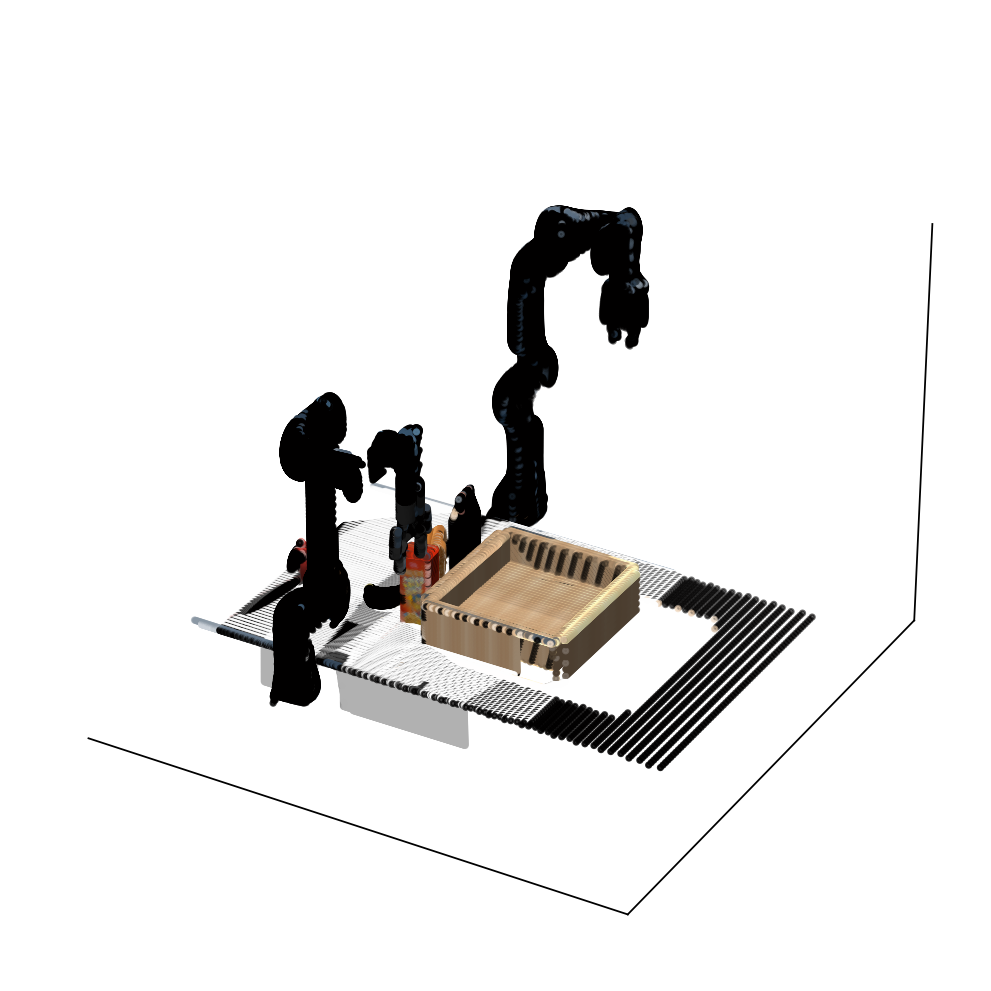

In [19]:
import matplotlib.pyplot as plt
import numpy as np
values, topk_ind = torch.topk(similarity, 100000)
fig = plt.figure(figsize=(6, 6), dpi=160)
ax = fig.add_subplot(111, projection="3d")


x, y, z = (
    xyz_pts[:, 0],
    xyz_pts[:, 1],
    xyz_pts[:, 2],
)
rgb_pts = outputs['rgb_pts']
rgb_pts[topk_ind.detach().cpu().numpy()] = np.array([1.0, 0.5, 0.0])
ax.set_facecolor((1.0, 1.0, 1.0))
ax.w_xaxis.set_pane_color((1.0, 1.0, 1.0))  # type: ignore
ax.w_yaxis.set_pane_color((1.0, 1.0, 1.0))  # type: ignore
ax.w_zaxis.set_pane_color((1.0, 1.0, 1.0))  # type: ignore

ax.scatter(
    x,
    y,
    z,
    c=rgb_pts.astype(float)/255.0,
    s=5,  # type: ignore
)

# Hide axes ticks
ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])  # type: ignore

plt.tight_layout(pad=0)
plt.show()
plt.close(fig)

In [11]:
print(similarity.shape)

torch.Size([1, 1041540])


In [10]:
print(max(similarity[0]))
print(min(similarity[0]))

tensor(0.3243, device='cuda:0')
tensor(0.2067, device='cuda:0')


In [10]:
outfeat = pixelwise_features.unsqueeze(0).float()  # interpolate is not implemented for float yet in pytorch
xyz_pts = torch.tensor(xyz_pts).unsqueeze(0).float().to(gpu_device)
print_mem_stats()

mem used gpu: 12183.87 MB, reserved gpu: 12206.00MB -> 54.17% of total, 54.27% reserved
mem used cpu: 3591.02 MB -> 7.45% of total


In [11]:
visual_encoder = None
pixelwise_features = None
mask_sim_mat = None
softmax_scores = None
feat_per_obj = None
scores = None
outputs = None
obj_sim_per_unit_area = None
del visual_encoder
del pixelwise_features
del mask_sim_mat
del softmax_scores
del feat_per_obj
del scores
del outputs
del obj_sim_per_unit_area
gc.collect()
torch.cuda.empty_cache()
print_mem_stats()

mem used gpu: 5620.26 MB, reserved gpu: 5662.00MB -> 24.99% of total, 25.17% reserved
mem used cpu: 3579.73 MB -> 7.43% of total


In [12]:
num_entries = outfeat.size(1)
num_to_keep = int(num_entries * 0.6)

# Generate a random permutation of indices and select the first 80%
indices = torch.randperm(num_entries)[:num_to_keep]

# Use the selected indices to downsample the tensors
outfeat_downsampled = outfeat[:, indices, :]
xyz_pts_downsampled = xyz_pts[:, indices, :]
print_mem_stats()

mem used gpu: 8983.94 MB, reserved gpu: 9022.00MB -> 39.94% of total, 40.11% reserved
mem used cpu: 3566.87 MB -> 7.40% of total


In [13]:
outfeat = None
xyz_pts = None
del outfeat
del xyz_pts
gc.collect()
print_mem_stats()

mem used gpu: 3377.81 MB, reserved gpu: 9022.00MB -> 15.02% of total, 40.11% reserved
mem used cpu: 3567.36 MB -> 7.40% of total


In [12]:
ckpt_path = "checkpoints/pretrain_blip2_sam_flant5xl_v2.pth"
model_cfg = {
    "arch": "blip2_t5",
    "model_type": "pretrain_flant5xl",
    "use_grad_checkpoint": False,
}
model_cfg = OmegaConf.create(model_cfg)
print_mem_stats()

mem used gpu: 5620.26 MB, reserved gpu: 5662.00MB -> 24.99% of total, 25.17% reserved
mem used cpu: 3579.98 MB -> 7.43% of total


In [13]:
model = registry.get_model_class("blip2_t5").from_pretrained(model_type="pretrain_flant5xl")
print_mem_stats()

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

mem used gpu: 5620.26 MB, reserved gpu: 5662.00MB -> 24.99% of total, 25.17% reserved
mem used cpu: 15473.13 MB -> 32.11% of total


In [14]:
checkpoint = torch.load(ckpt_path, map_location="cpu")
print_mem_stats()

mem used gpu: 5620.26 MB, reserved gpu: 5662.00MB -> 24.99% of total, 25.17% reserved
mem used cpu: 19732.29 MB -> 40.95% of total


In [15]:
model.load_state_dict(checkpoint["model"], strict=False)
print_mem_stats()

mem used gpu: 5620.26 MB, reserved gpu: 5662.00MB -> 24.99% of total, 25.17% reserved
mem used cpu: 19731.86 MB -> 40.95% of total


In [16]:
model.eval()
print_mem_stats()

mem used gpu: 5620.26 MB, reserved gpu: 5662.00MB -> 24.99% of total, 25.17% reserved
mem used cpu: 19730.42 MB -> 40.94% of total


In [17]:
processor_cfg = {"name": "blip_question", "prompt": ""}
processor_cfg = OmegaConf.create(processor_cfg)
text_processor = registry.get_processor_class(processor_cfg.name).from_config(processor_cfg)
print_mem_stats()

mem used gpu: 5620.26 MB, reserved gpu: 5662.00MB -> 24.99% of total, 25.17% reserved
mem used cpu: 19731.89 MB -> 40.95% of total


In [18]:
outfeat.shape

torch.Size([1, 1041540, 1408])

In [ ]:
# outfeat_downsampled = outfeat_downsampled.to(cpu_device)
# xyz_pts_downsampled = xyz_pts_downsampled.to(cpu_device)
outfeat = outfeat.to(cpu_device)
xyz_pts = xyz_pts.to(cpu_device)
prompt = text_processor("describe the scene")
# model_inputs = {"text_input": prompt, "pc_feat": outfeat_downsampled, "pc": xyz_pts_downsampled}
model_inputs = {"text_input": prompt, "pc_feat": outfeat, "pc": xyz_pts}
model_outputs = model.predict_answers(
    samples=model_inputs,
    max_len=50,
    length_penalty=1.2,
    repetition_penalty=1.5,
)
model_outputs = model_outputs[0]
print(model_outputs)
print_mem_stats()

In [ ]:
model = None
text_processor = None
outfeat_downsampled = None
xyz_pts_downsampled = None
checkpoint = None
del model
del text_processor
del outfeat_downsampled
del xyz_pts_downsampled
del checkpoint
gc.collect()
torch.cuda.empty_cache()
print_mem_stats()

mem used gpu: 21.10 MB, reserved gpu: 42.00MB -> 0.09% of total, 0.19% reserved
mem used cpu: 15368.57 MB -> 31.89% of total
